# **SpaceX  Falcon 9 First Stage Landing Prediction**


## Machine Learning Prediction of Falcon 9 First-Stage Landings


SpaceX offers **Falcon 9** rocket launches at a cost of **\$62 million**, significantly lower than other providers, whose prices exceed **\$165 million** per launch. This cost advantage is largely attributed to SpaceX's ability to **reuse the first stage** of the rocket.  

Accurately predicting the **likelihood of a first-stage landing** enables a more precise estimation of launch costs. This information is valuable for aerospace firms seeking to **compete with SpaceX** in the commercial launch market by offering competitive pricing strategies.  

This analysis involves developing a **machine learning pipeline** to assess the probability of a **first-stage landing**, leveraging data from previous missions.



## Overview of the Methodology

### Data Preparation  

- Standardisation of the dataset to ensure **uniform scaling** of numerical features.  
- Splitting of the dataset into **training** and **test** sets for model evaluation.  

### Model Selection and Hyperparameter Optimisation  

- Identification of **optimal hyperparameters** for the following classification models:  
  - **Support Vector Machine (SVM)**  
  - **Decision Trees**  
  - **Logistic Regression**  
  - **K-Nearest Neighbours (KNN)**  

### Model Evaluation  

- Assessment of model performance using the **test dataset**.  
- Comparison of classification methods based on **accuracy and other evaluation metrics**.  



## Importing Libraries and Auxiliary Functions



In [1]:
# Data manipulation and numerical computing
import pandas as pd  # DataFrame manipulation and analysis
import numpy as np   # Numerical computations and array operations

# Data visualization
import matplotlib.pyplot as plt  # Standard plotting library
import seaborn as sns  # Statistical data visualization

# System utilities and file handling
import os       # Operating system functions 
import pickle   # Serialization and deserialization of Python objects
import datetime # Date and time handling

# Machine Learning utilities
from sklearn import preprocessing  # Data preprocessing, including standardization and normalization

# Model selection and evaluation
from sklearn.model_selection import train_test_split  # Splits data into training and testing sets
from sklearn.model_selection import GridSearchCV      # Performs hyperparameter tuning using cross-validation

# Machine Learning models
from sklearn.linear_model import LogisticRegression   # Logistic Regression classifier
from sklearn.svm import SVC                           # Support Vector Machine classifier
from sklearn.tree import DecisionTreeClassifier       # Decision Tree classifier
from sklearn.neighbors import KNeighborsClassifier    # k-Nearest Neighbors classifier

# SpaceX-specific modules (custom or third-party)
import spacex  # Custom or third-party SpaceX module

# Importing directory paths from SpaceX configuration
from spacex.config import RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, FIGURES_DIR

# Pandas display settings (adjusts output formatting)
pd.set_option('display.max_rows', None)      # Show all rows in DataFrame display
pd.set_option('display.max_columns', None)   # Show all columns in DataFrame display


The following function will be used to plot the confusion matrix.


In [2]:
def plot_confusion_matrix(y, y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

## Load the dataframe


The pickle file will be downloaded.


In [3]:
pickle_file = os.path.join(INTERIM_DATA_DIR, 'dataset_part_2.pkl')
data = pd.read_pickle(pickle_file)

# Filter the dataset to include only Falcon 9 booster versions
data = data[data['Booster_Version']=='Falcon 9']

In [4]:
data.sample(5)

,Date,Time (UTC),Booster_Version,Serial,Launch_Site,Facility,Complex,Longitude,Latitude,Payload,Payload_Mass,Customer,Orbit,Mission_Outcome,Launch_Outcome,Booster_Landing,Landing_Pad,Block,Flights,GridFins,Legs,Reused,Reused_Count,date_utc,Flight_Number,Class
4,2013-03-01,15:10:00,Falcon 9,B0007,CCSFS SLC-40,CCSFS,SLC-40,-80.577366,28.561857,SpaceX CRS-2,677.0,NASA (CRS),ISS,None None,Success,No attempt,NaN,1.0,1.0,False,False,False,0.0,2013-03-01 19:10:00+00:00,5,0
74,2019-11-11,14:56:00,Falcon 9,B1048,CCSFS SLC-40,CCSFS,SLC-40,-80.577366,28.561857,Starlink,15600.0,SpaceX,VLEO,True ASDS,Success,Success,5e9e3032383ecb6bb234e7ca,5.0,4.0,True,True,True,4.0,2019-11-11 14:56:00+00:00,75,1
14,2015-02-11,23:03:00,Falcon 9,B1013,CCSFS SLC-40,CCSFS,SLC-40,-80.577366,28.561857,DSCOVR,570.0,NASA,ES-L1,True Ocean,Success,Controlled,NaN,1.0,1.0,True,True,False,0.0,2015-02-11 23:03:00+00:00,15,1
41,2017-10-09,12:37:00,Falcon 9,B1041,VAFB SLC-4E,VAFB,SLC-4E,-120.610829,34.632093,Iridium NEXT,9600.0,Iridium Communications,PO,True ASDS,Success,Success,5e9e3033383ecbb9e534e7cc,4.0,1.0,True,True,False,1.0,2017-10-09 12:37:00+00:00,42,1
59,2018-08-07,05:18:00,Falcon 9,B1046,CCSFS SLC-40,CCSFS,SLC-40,-80.577366,28.561857,Merah Putih,5800.0,Telkom,GTO,True ASDS,Success,Success,5e9e3032383ecb6bb234e7ca,5.0,2.0,True,True,True,3.0,2018-08-07 05:18:00+00:00,60,1


In [5]:
pickle_file = os.path.join(INTERIM_DATA_DIR, 'dataset_part_3.pkl')
X = pd.read_pickle(pickle_file)
X.sample(5)

,Flight_Number,Payload_Mass,Flights,Block,Reused_Count,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SSO,Orbit_VLEO,Launch_Site_CCSFS SLC-40,Launch_Site_KSC LC-39A,Launch_Site_VAFB SLC-4E,Landing_Pad_5e9e3032383ecb267a34e7c7,Landing_Pad_5e9e3032383ecb554034e7c9,Landing_Pad_5e9e3032383ecb6bb234e7ca,Landing_Pad_5e9e3032383ecb761634e7cb,Landing_Pad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
35,36.0,3669.000000,2.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
0,1.0,6123.547647,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
32,33.0,6123.547647,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
61,62.0,2800.000000,2.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
9,10.0,1316.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## TASK 1 - Prepare data for the analysis

A NumPy array is to be generated from the `Class` column in `data` using the `to_numpy()` method. The result must be assigned to the variable `Y`, ensuring that the output remains a Pandas Series by applying single-bracket notation (`df['column_name']`).

In [6]:
Y = data['Class'].to_numpy()
type(Y)

numpy.ndarray

The data in `X` is standardised, and the transformed values are reassigned to the variable `X` using the transformation method provided below.  

In [7]:
transform = preprocessing.StandardScaler()

In [8]:
transform.fit(X)
X = transform.transform(X)

## TASK 2 Divide data into **Train** and **Test** data


The dataset is partitioned into training and testing sets using the `train_test_split` function. The training set is further subdivided into validation data, which acts as a secondary dataset for training. The models are then trained, and hyperparameters are optimised using the `GridSearchCV` function.  

The `train_test_split` function is applied to `X` and `Y` to create training and test datasets. The parameter `test_size` is set to `0.2`, and `random_state` is set to `2`. The resulting datasets are assigned to the corresponding variables:  

`X_train, X_test, Y_train, Y_test`



In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=2)

Only 18 test samples are available, highlighting the dataset’s limited size.


In [10]:
display(Y_test.shape)
display(Y_train.shape)

(18,)

(71,)

## TASK 3 Modelling

### Logistic Regression

A logistic regression object is created, followed by the instantiation of a `GridSearchCV` object as `logreg_cv` with `cv=10`. The object is then fitted to determine the optimal parameters from the `parameters` dictionary.  


In [11]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [12]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv=GridSearchCV(lr, parameters,cv=10)
logreg_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

The `GridSearchCV` object for logistic regression is output. The optimal parameters are displayed using the `best_params_` attribute, while the accuracy on the validation data is presented using the `best_score_` attribute.  


In [13]:
print("Tuned hyperparameters: (best parameters) ",logreg_cv.best_params_)
print("Accuracy :",logreg_cv.best_score_)

Tuned hyperparameters: (best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.8464285714285713


The accuracy on the test data is calculated using the `score` method.  

In [14]:
print('Out-of-sample evaluation score:', logreg_cv.score(X_test,Y_test))
print('In-sample evaluation score: ', logreg_cv.score(X_train,Y_train))


Out-of-sample evaluation score: 0.8333333333333334
In-sample evaluation score:  0.9436619718309859


In [15]:
accuracy_ML_data=[{'model':'Logistic Regression','Out-of-Sample-Score':logreg_cv.score(X_test,Y_test),
                  'In-Sample-Score':logreg_cv.score(X_train,Y_train),'Best Grid CV score':logreg_cv.best_score_}]
accuracy_ML=pd.DataFrame(accuracy_ML_data)
accuracy_ML

,model,Out-of-Sample-Score,In-Sample-Score,Best Grid CV score
0,Logistic Regression,0.833333,0.943662,0.846429


The confusion matrix is presented:


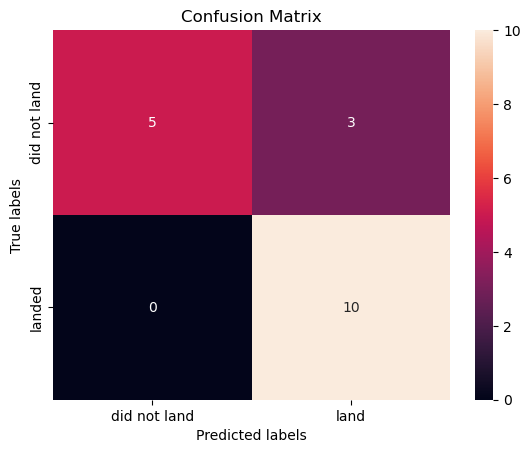

In [16]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

An examination of the confusion matrix indicates that **logistic regression** effectively differentiates between the classes. However, the primary issue is the occurrence of false positives.  


### Support Vector Machine (SVM) 

A support vector machine object is created, followed by the instantiation of a `GridSearchCV` object as `svm_cv` with `cv=10`. The object is then fitted to identify the optimal parameters from the `parameters` dictionary.  

In [17]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [18]:
svm_cv=GridSearchCV(svm, parameters,cv=10)
svm_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [19]:
# Convert np.float64 values to standard float format
best_params_cleaned = {key: float(value) if isinstance(value, np.float64) else value for key, value in svm_cv.best_params_.items()}

print(f"Tuned hyperparameters (best parameters): {best_params_cleaned}")
print(f"Accuracy: {svm_cv.best_score_:.2f}")

Tuned hyperparameters (best parameters): {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Accuracy: 0.85


In [20]:
dict_ML=['SVM',
         svm_cv.score(X_test,Y_test),
         svm_cv.score(X_train,Y_train),
         svm_cv.best_score_]

accuracy_ML.loc[len(accuracy_ML)] = dict_ML
accuracy_ML

,model,Out-of-Sample-Score,In-Sample-Score,Best Grid CV score
0,Logistic Regression,0.833333,0.943662,0.846429
1,SVM,0.833333,0.873239,0.846429


In [21]:
print('Out-of-sample evaluation score:', svm_cv.score(X_test,Y_test))
print('In-sample evaluation score: ', svm_cv.score(X_train,Y_train))

Out-of-sample evaluation score: 0.8333333333333334
In-sample evaluation score:  0.8732394366197183


The confusion matrix is visualised to assess model performance.



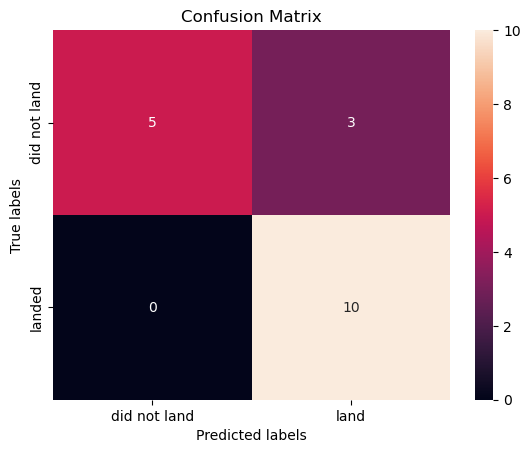

In [22]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Decision Tree Classifier

A decision tree classifier is created, and `GridSearchCV` is used with `cv=10` to optimise hyperparameters from the `parameters` dictionary.
 

In [23]:
np.random.seed(1)
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [24]:
tree_cv=GridSearchCV(tree, parameters,cv=10)
tree_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [25]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
accuracy : 0.8910714285714285


The accuracy of `tree_cv` is determined on the test data using the `score` method.  


In [26]:
print('Out-of-sample evaluation score:', tree_cv.score(X_test,Y_test))
print('In-sample evaluation score: ', tree_cv.score(X_train,Y_train))

Out-of-sample evaluation score: 0.8333333333333334
In-sample evaluation score:  0.8169014084507042


In [27]:
dict_ML=['Decission_Tree',
         tree_cv.score(X_test,Y_test),
         tree_cv.score(X_train,Y_train),
         tree_cv.best_score_]

accuracy_ML.loc[len(accuracy_ML)] = dict_ML
accuracy_ML

,model,Out-of-Sample-Score,In-Sample-Score,Best Grid CV score
0,Logistic Regression,0.833333,0.943662,0.846429
1,SVM,0.833333,0.873239,0.846429
2,Decission_Tree,0.833333,0.816901,0.891071


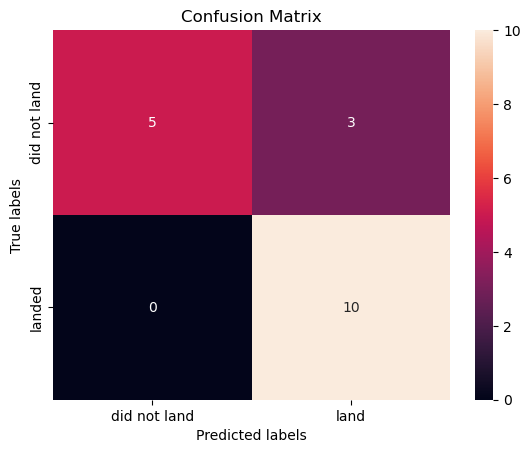

In [28]:
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### K-nearest Classifier

A k-nearest neighbors object is created, followed by the instantiation of a `GridSearchCV` object as `knn_cv` with `cv=10`. The object is then fitted to identify the optimal parameters from the `parameters` dictionary.  

In [29]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [30]:
knn_cv=GridSearchCV(KNN, parameters,cv=10)
knn_cv.fit(X_train,Y_train)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [31]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}
accuracy : 0.875


The accuracy of `KNN` is determined on the test data using the `score` method.  


In [32]:
print('Out-of-sample evaluation score:', knn_cv.score(X_test,Y_test))
print('In-sample evaluation score: ', knn_cv.score(X_train,Y_train))

Out-of-sample evaluation score: 0.8333333333333334
In-sample evaluation score:  0.8732394366197183


The confusion matrix is visualised to assess model performance.



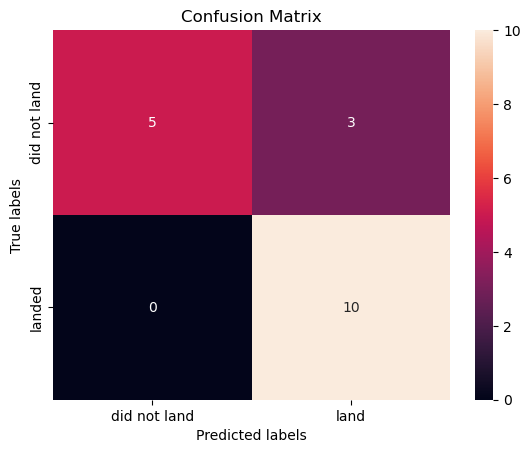

In [33]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [34]:
dict_ML=['K-Near_Neighbour',
         knn_cv.score(X_test,Y_test),
         knn_cv.score(X_train,Y_train),
         knn_cv.best_score_]

accuracy_ML.loc[len(accuracy_ML)] = dict_ML
accuracy_ML

,model,Out-of-Sample-Score,In-Sample-Score,Best Grid CV score
0,Logistic Regression,0.833333,0.943662,0.846429
1,SVM,0.833333,0.873239,0.846429
2,Decission_Tree,0.833333,0.816901,0.891071
3,K-Near_Neighbour,0.833333,0.873239,0.875000


## TASK 4 Comparison of Model Performance and Conclusion

The model scores are visualised for comparison.


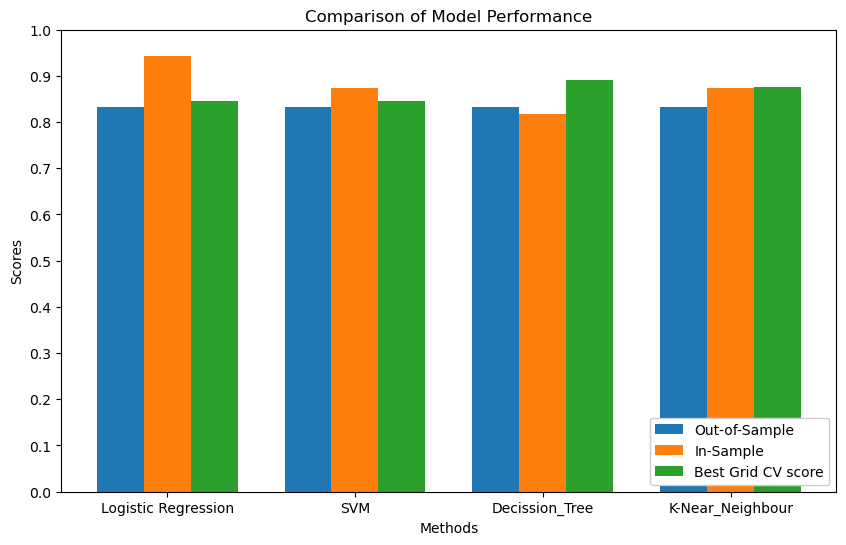

In [35]:
# Ensure accuracy_ML is correctly structured with the models as the index
models = accuracy_ML['model']  # Four models (e.g., SVM, Decision Tree, Logistic Regression, KNN)
scores = ['Out-of-Sample-Score', 'In-Sample-Score', 'Best Grid CV score']  # Three score types

# Number of models and bar width
N = len(models) 
ind = np.arange(N)  
width = 0.25  # Width of the bars

# Plot accuracy scores for all models
plt.figure(figsize=(10, 6))
bar1 = plt.bar(ind, 
               accuracy_ML['Out-of-Sample-Score'], 
               width, color = '#1f77b4')
bar2 = plt.bar(ind+width, 
               accuracy_ML['In-Sample-Score'], 
               width, color='#ff7f0e')
bar3 = plt.bar(ind+width*2, 
               accuracy_ML['Best Grid CV score'], 
               width, color = '#2ca02c')
  
plt.xlabel('Methods')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
  
plt.xticks(ind+width, models)
plt.yticks(np.linspace(0, 1, 11))
plt.legend( (bar1, bar2, bar3), ('Out-of-Sample', 'In-Sample', 'Best Grid CV score') , loc=4, framealpha=1)
plt.show()

### CONCLUSION

**All methods** yield a similar performance, with an accuracy score of **0.8333**.  

- **Logistic Regression** achieves the highest in-sample score of **0.944**.  
- **Decision Tree** exhibits the smallest discrepancy between in-sample and out-of-sample scores, with an in-sample score of **0.891**.  

While **all models** exhibit similar test performance, **Logistic Regression** achieves the highest in-sample accuracy, whereas the **Decision Tree** offers better generalisation.


Copyright © 2020 IBM Corporation. All rights reserved.
